In [1]:
!git clone https://github.com/KORALLLL/diffusion.git
!pip install torcheval
!pip install diffusers

Cloning into 'diffusion'...
remote: Enumerating objects: 322, done.
remote: Counting objects: 100% (322/322), done.
remote: Compressing objects: 100% (225/225), done.
remote: Total 322 (delta 180), reused 228 (delta 90), pack-reused 0 (from 0)
Receiving objects: 100% (322/322), 9.76 MiB | 24.44 MiB/s, done.
Resolving deltas: 100% (180/180), done.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 1.7 MB/s eta 0:00:00 0:00:010m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 12.5 MB/s eta 0:00:0000:0100:01


In [2]:
import pickle,gzip,math,os,time,shutil,torch,random, sys
import fastcore.all as fc,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager
from scipy import linalg

from fastcore.foundation import L
import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('/kaggle/working/diffusion'))

from diffusion.data_utils import *
from diffusion.learners import *
from diffusion.callbacks import *
from diffusion.metrics import *
from diffusion.utils import *
from diffusion.modules import *

In [3]:
from fastcore.test import test_close
from torch import distributions

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray_r'

import logging
logging.disable(logging.WARNING)

set_seed(42)
if fc.defaults.cpus>8: fc.defaults.cpus=8

# Classifier

In [4]:
from diffusers import UNet2DModel

0it [00:00, ?it/s]

In [5]:
class UNet(UNet2DModel):
    def forward(self, x): return super().forward(*x).sample

In [8]:
from types import SimpleNamespace
def linear_sched(betamin=0.0001, betamax=0.02, n_steps=1000):
    beta = torch.linspace(betamin, betamax, n_steps)
    return SimpleNamespace(a=1.-beta, abar=(1.-beta).cumprod(dim=0), sig=beta.sqrt())


xl,yl = 'image','label'
name = "fashion_mnist"
bs = 512

@inplace
def transformi(b): b[xl] = [F.pad(TF.to_tensor(o), (2,2,2,2))*2-1 for o in b[xl]]

dsd = load_dataset(name)
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=fc.defaults.cpus)

n_steps = 1000
lin_abar = linear_sched(betamax=0.01)
alphabar = lin_abar.abar
alpha = lin_abar.a
sigma = lin_abar.sig


collatefn = partial(collate_ddpm, alphabar=alphabar, xl='image')
dls = DataLoaders(dl_ddpm(tds['train'], bs=bs, nw=4, collate_fn=collatefn),
                  dl_ddpm(tds['test'],  bs=bs, nw=4, collate_fn=collatefn))

Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [9]:
lr = 5e-3
epochs = 5
opt_func = partial(optim.Adam, eps=1e-5)
tmax = epochs * len(dls.train) * 2 +1
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)

cbs = [DeviceCB(), AccelerateCB(n_inp=1), ProgressCB(plot=True), MetricsCB(), BatchSchedCB(sched), MultiGPUsCallback()]
model = UNet(in_channels=1, out_channels=1, block_out_channels=(16, 32, 64, 128), norm_num_groups=8)
init_ddpm(model)
learn = Learner(model, dls, nn.MSELoss(), lr=lr, cbs=cbs, opt_func=opt_func)

/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:488: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Using 2 GPUs for training


loss,epoch,train
0.359,0,True
0.081,0,False
0.062,1,True
0.059,1,False
0.051,2,True
0.050,2,False
0.046,3,True
0.045,3,False
0.045,4,True
0.044,4,False


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


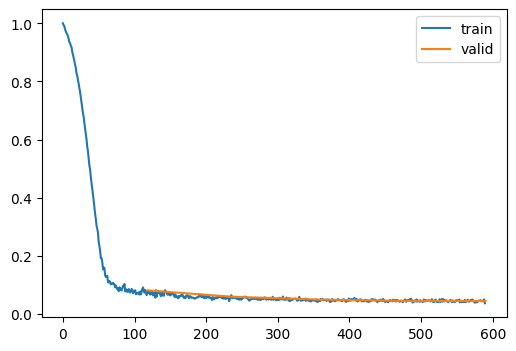

In [10]:
learn.fit(epochs)

In [11]:
torch.save(learn.model, 'model_ddpm.pth')

Using 2 GPUs for training


accuracy,loss,epoch,train
0.699,1.037,0,True
0.744,0.788,0,False
0.793,0.748,1,True
0.775,0.707,1,False
0.824,0.629,2,True
0.807,0.584,2,False
0.830,0.565,3,True
0.804,0.578,3,False
0.846,0.489,4,True
0.862,0.402,4,False


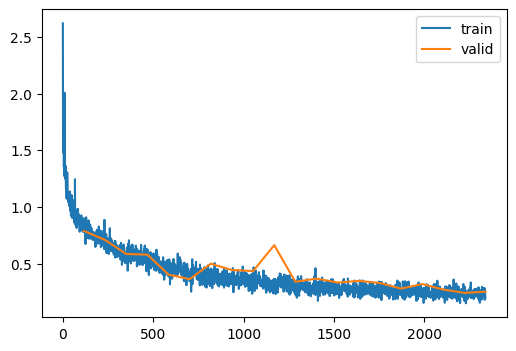

In [12]:

from torchvision import transforms

xl,yl = 'image','label'
name = "fashion_mnist"
bs = 512

@inplace
def transformi(b): b[xl] = [(TF.to_tensor(o)*2-1) for o in b[xl]]
    
dsd = load_dataset(name)
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=fc.defaults.cpus)

def get_model(act=nn.ReLU, nfs=(16,32,64,128,256,512), norm=nn.BatchNorm2d):
    layers = [ResBlock(1, 16, ks=5, stride=1, act=act, norm=norm)]
    layers += [ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2) for i in range(len(nfs)-1)]
    layers += [nn.Flatten(), nn.Linear(nfs[-1], 10, bias=False), nn.BatchNorm1d(10)]
    return nn.Sequential(*layers)


def tfm_batch(b, tfm_x=fc.noop, tfm_y = fc.noop): return tfm_x(b[0]),tfm_y(b[1])
tfms = nn.Sequential(transforms.RandomCrop(28, padding=4),
                     transforms.RandomHorizontalFlip())
augcb = BatchTransformCB(partial(tfm_batch, tfm_x=tfms), on_val=False)

iw = partial(init_weights, leaky=0.1)
metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [MultiGPUsCallback(), metrics, ProgressCB(plot=True)]

set_seed(42)
epochs = 20
lr = 1e-2
tmax = 2 * epochs * len(dls.train) + 1
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched), augcb]
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs)

In [16]:
xl,yl = 'image','label'
name = "fashion_mnist"
bs = 512

@inplace
def transformi(b): b[xl] = [F.pad(TF.to_tensor(o), (2,2,2,2))*2-1 for o in b[xl]]

dsd = load_dataset(name)
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=fc.defaults.cpus)

In [17]:
b = xb,yb = next(iter(dls.train))

In [15]:
torch.save(learn.model, 'model_classification.pth')

In [18]:
cbs = [DeviceCB(device='cuda:0'), TrainCB()]
model = torch.load('model_classification.pth')
learn = Learner(model, dls, F.cross_entropy, cbs=cbs, opt_func=None)

/tmp/ipykernel_36/1531766703.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('model_classification.pth')


In [19]:
def append_outp(hook, mod, inp, outp):
    if not hasattr(hook, 'outp'): hook.outp =[]
    hook.outp.append(to_cpu(outp))

In [20]:
hcb = HooksCallback(append_outp, mods=[model[6]], on_valid=True)

In [21]:
learn.fit(1, train=False, cbs=[hcb])

In [22]:
feats = hcb.hooks[0].outp[0][:64]
feats.shape

torch.Size([64, 512])

In [23]:
del(learn.model[8])
del(learn.model[7])

In [24]:
@fc.patch
def capture_preds(self: Learner, cbs=None, inps=False):
    cp = CapturePredsCB()
    self.fit(1, train=False, cbs=[cp]+fc.L(cbs))
    res = cp.all_preds,cp.all_targs
    if inps: res = res+(cp.all_inps,)
    return res

In [ ]:
feats, y = learn.capture_preds()
feats = torch.cat(feats).float()
feats.shape, y

In [27]:
feats

tensor([[ -11644.13,  -87286.80, 1410935.38,  ...,  -58581.36,  -29093.06,  -36387.99],
        [ -69918.08, -169715.03,   81235.70,  ...,  -69410.46, 1497346.88,  -11055.86],
        [ -48826.27,  104786.82, 1524809.62,  ..., 1440675.12,  -64070.99, 1491082.25],
        ...,
        [ -37008.13,  229954.25,  -31332.89,  ...,  -51014.74, 1261707.88,  -34553.39],
        [ -11753.93, -121895.80, 1565965.75,  ...,  -83775.92,  -71191.86,  -43351.21],
        [ -87483.23, -175285.64,  -80731.85,  ..., -124135.20, -182607.70,  830158.12]])

# Calc FID

In [28]:
smodel = torch.load("model_ddpm.pth")

/tmp/ipykernel_36/254313060.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  smodel = torch.load("model_ddpm.pth")


In [29]:
dls2 = DataLoaders(dl_ddpm(tds['train'], bs=bs, nw=4, collate_fn=collatefn),
                  dl_ddpm(tds['test'],  bs=bs, nw=4, collate_fn=collatefn))

In [30]:
%%time
samples = sample(smodel, (256, 1, 32, 32), alpha, alphabar, sigma, n_steps)

0it [00:00, ?it/s]

CPU times: user 1min 36s, sys: 679 ms, total: 1min 37s
Wall time: 1min 36s


In [31]:
s = samples[-1] * 2 + 1

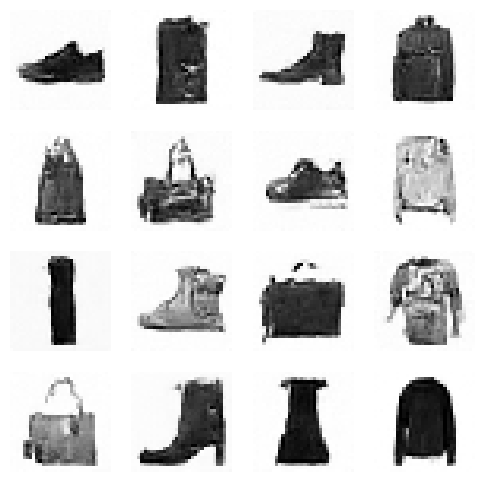

In [32]:
show_images(s[:16], imsize=1.5)

In [33]:
class CapturePreds(Callback):
    def before_fit(self, learn): self.all_inps,self.all_preds,self.all_targs = [],[],[]
    def after_batch(self, learn):
        self.all_inps. append(to_cpu(learn.batch[0]))
        self.all_preds.append(to_cpu(learn.preds))
        self.all_targs.append(to_cpu(learn.batch[1]))
    def after_fit(self, learn):
        self.all_preds,self.all_targs,self.all_inps = map(torch.cat, [self.all_preds,self.all_targs,self.all_inps])

@fc.patch
def capture_preds(self: Learner, cbs=None, inps=False):
    cp = CapturePreds()
    self.fit(1, train=False, cbs=[cp]+fc.L(cbs))
    res = cp.all_preds,cp.all_targs
    if inps: res = res+(cp.all_inps,)
    return res

clearn = TrainLearner(model, DataLoaders([], [(s, yb)]), loss_func=fc.noop, cbs=[DeviceCB(device='cuda:0')], opt_func=None)
feats2, y2 = clearn.capture_preds()
feats2 = feats2.float().squeeze()
feats2.shape

torch.Size([256, 512])

In [34]:
means = feats.mean(0)
means.shape

torch.Size([512])

In [35]:
covs = feats.T.cov()
covs.shape

torch.Size([512, 512])

In [36]:
# export

from tqdm.notebook import tqdm

def _sqrt_newton_shulz(mat, num_iter=100):
    mat_nrm = mat.norm()
    mat = mat.double()
    Y = mat / mat_nrm
    n = len(mat)
    I = torch.eye(n, n).to(mat)
    Z = torch.eye(n, n).to(mat)
    
    for i in range(num_iters):
        T = (3 * I - Z @ Y) / 2
        Y, Z = Y @ T, T @ Z
        res = Y * mat_nrm.sqrt()
        if ((mat - (res@res)).norm() / mat_norm).abs() <=1e-6: break
    return res

In [37]:

#|export
def _calc_stats(feats):
    feats = feats.squeeze()
    return feats.mean(0),feats.T.cov()

def _calc_fid(m1,c1,m2,c2):
#     csr = _sqrtm_newton_schulz(c1@c2)
    csr = tensor(linalg.sqrtm(c1@c2, 256).real)
    return (((m1-m2)**2).sum() + c1.trace() + c2.trace() - 2*csr.trace()).item()

In [38]:
s1,s2 = _calc_stats(feats),_calc_stats(feats2)
     

In [39]:
feats2.shape

torch.Size([256, 512])

In [40]:
_calc_fid(*s1, *s2)

/opt/conda/lib/python3.10/site-packages/numpy/linalg/linalg.py:2550: RuntimeWarning: overflow encountered in scalar add
  sqnorm = x_real.dot(x_real) + x_imag.dot(x_imag)


214583042113536.0

In [41]:
feats

tensor([[ -11644.13,  -87286.80, 1410935.38,  ...,  -58581.36,  -29093.06,  -36387.99],
        [ -69918.08, -169715.03,   81235.70,  ...,  -69410.46, 1497346.88,  -11055.86],
        [ -48826.27,  104786.82, 1524809.62,  ..., 1440675.12,  -64070.99, 1491082.25],
        ...,
        [ -37008.13,  229954.25,  -31332.89,  ...,  -51014.74, 1261707.88,  -34553.39],
        [ -11753.93, -121895.80, 1565965.75,  ...,  -83775.92,  -71191.86,  -43351.21],
        [ -87483.23, -175285.64,  -80731.85,  ..., -124135.20, -182607.70,  830158.12]])

In [42]:
def _squared_mmd(x, y):
    def k(a,b): return (a@b.transpose(-2,-1)/a.shape[-1]+1)**3
    m,n = x.shape[-2],y.shape[-2]
    kxx,kyy,kxy = k(x,x), k(y,y), k(x,y)
    kxx_sum = kxx.sum([-1,-2])-kxx.diagonal(0,-1,-2).sum(-1)
    kyy_sum = kyy.sum([-1,-2])-kyy.diagonal(0,-1,-2).sum(-1)
    kxy_sum = kxy.sum([-1,-2])
    return kxx_sum/m/(m-1) + kyy_sum/n/(n-1) - kxy_sum*2/m/n

In [43]:
def _calc_kid(x, y, maxs=50):
    xs,ys = x.shape[0],y.shape[0]
    n = max(math.ceil(min(xs/maxs, ys/maxs)), 4)
    mmd = 0.
    for i in range(n):
        cur_x = x[round(i*xs/n) : round((i+1)*xs/n)]
        cur_y = y[round(i*ys/n) : round((i+1)*ys/n)]
        mmd += _squared_mmd(cur_x, cur_y)
    return (mmd/n).item()

In [44]:
_calc_kid(feats, feats2)

nan

In [45]:
#|export
class ImageEval:
    def __init__(self, model, dls, cbs=None):
        self.learn = TrainLearner(model, dls, loss_func=fc.noop, cbs=cbs, opt_func=None)
        self.feats = self.learn.capture_preds()[0].float().cpu().squeeze()
        self.stats = _calc_stats(self.feats)

    def get_feats(self, samp):
        self.learn.dls = DataLoaders([],[(samp, tensor([0]))])
        return self.learn.capture_preds()[0].float().cpu().squeeze()

    def fid(self, samp): return _calc_fid(*self.stats, *_calc_stats(self.get_feats(samp)))
    def kid(self, samp): return _calc_kid(self.feats, self.get_feats(samp))

In [46]:
ie = ImageEval(model, learn.dls, cbs=[DeviceCB()])

In [47]:
%%time
ie.fid(s)

CPU times: user 2.41 s, sys: 415 ms, total: 2.82 s
Wall time: 883 ms


214920029274112.0

In [48]:
%%time
ie.kid(s)

CPU times: user 653 ms, sys: 128 ms, total: 781 ms
Wall time: 391 ms


nan

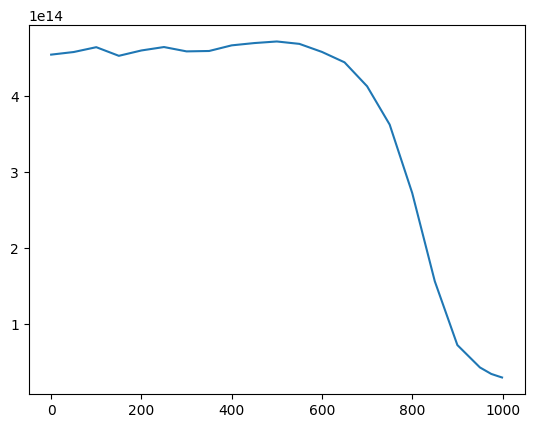

In [49]:
xs = L.range(0,1000,50)+[975,990,999]
plt.plot(xs, [ie.fid(samples[i].clamp(-0.5,0.5)*2) for i in xs]);

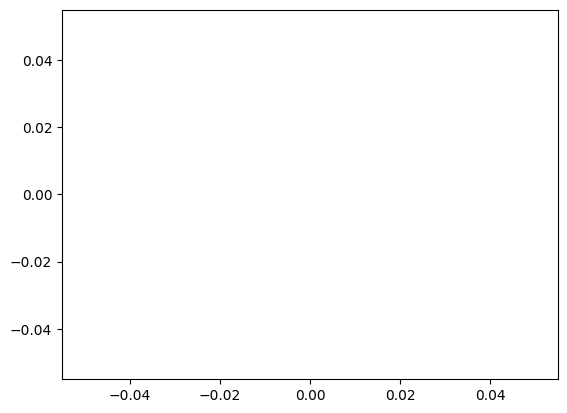

In [50]:
s = L.range(0,1000,50)+[975,990,999]
plt.plot(xs, [ie.kid(samples[i].clamp(-0.5,0.5)*2) for i in xs]);

In [51]:
ie.fid(xb)

2583959699456.0

In [52]:
ie.kid(xb)

nan

# Inception

In [54]:
!pip install pytorch_fid
from pytorch_fid.inception import InceptionV3

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [55]:
a = tensor([1,2,3])
a.repeat((3,1))

tensor([[1, 2, 3],
        [1, 2, 3],
        [1, 2, 3]])

In [56]:
class IncepWrap(nn.Module):
    def __init__(self):
        super().__init__()
        self.m = InceptionV3(resize_input=True)
    def forward(self, x): return self.m(x.repeat(1,3,1,1))[0]

In [57]:
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=fc.defaults.cpus)

In [81]:
class testCB(Callback):
    def __init__(self): i = 0
    def after_batch(self, *args, **kwargs):
        print(1)

In [82]:
ie = ImageEval(IncepWrap(), dls, cbs=[DeviceCB(device='cuda:0'), testCB()])

1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


In [84]:
ie.fid(xb)

1


27.9334716796875

In [88]:
ie.kid(xb)

1


-0.00011741031630663201